# Main Script Bank Telemarketing Dataset

First required packages and the data is loaded. Note that both the training- and validation dataset as well as the test dataset are taken from the bank-full.csv dataset. A random sampel of 6'000 nodes is taken for both subsets. 

If the dataset would be considered for the results chapter, the dataset would have first been randomly split into two datasets and then subsampled separately. The results do however not differ in any significant way. When sampling from the same dataset, technically identical observations could be present in both training and test dataset. Given the large size of the original datset with over 45'000 observations, this is unlikely to cause a problem or significantly bias the results.

In [101]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [102]:
df = pd.read_csv('bank-full.csv',sep=';')
df_train_valid = df.sample(n=6000,replace=False)
df_feature_train = df_train_valid.copy(deep=True)
# df_train_valid = pd.read_csv('bank.csv',sep=';')
df_train_valid.reset_index(inplace=True,drop=True)
df_test = df.sample(n=6000,replace=False)
df_test.reset_index(inplace=True,drop=True)

Below the unbalanced label distribution for both datasets is shown

In [103]:
df_train_valid.y.value_counts(normalize=True)

no     0.8865
yes    0.1135
Name: y, dtype: float64

In [104]:
df_test.y.value_counts(normalize=True)

no     0.885333
yes    0.114667
Name: y, dtype: float64

In [105]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,37,admin.,married,secondary,no,0,yes,no,telephone,15,jul,280,6,-1,0,unknown,no
1,51,services,single,secondary,no,513,yes,no,cellular,29,jul,331,2,-1,0,unknown,no
2,44,blue-collar,married,secondary,no,508,yes,no,cellular,17,nov,158,1,-1,0,unknown,no
3,41,management,divorced,tertiary,no,4567,yes,yes,cellular,16,jul,106,1,-1,0,unknown,no
4,31,technician,married,secondary,no,310,yes,no,cellular,20,aug,228,2,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,55,technician,married,secondary,no,312,no,no,cellular,6,feb,13,8,9,3,other,no
5996,26,self-employed,single,tertiary,no,458,yes,yes,cellular,2,feb,117,7,-1,0,unknown,no
5997,39,unemployed,single,secondary,no,-114,yes,no,cellular,3,feb,372,1,-1,0,unknown,yes
5998,35,management,single,secondary,yes,-202,yes,no,unknown,20,may,268,3,-1,0,unknown,no


## The variables are recoded into a useful format

In [106]:
df_train_valid.age = df_train_valid.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_train_valid.job = df_train_valid.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_train_valid.marital = df_train_valid.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_train_valid.education = df_train_valid.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_train_valid.default = df_train_valid.default.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.balance = df_train_valid.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_train_valid.housing = df_train_valid.housing.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.loan = df_train_valid.loan.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.contact = df_train_valid.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

#df_train_valid.duration = df_train_valid.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_train_valid.pdays = df_train_valid.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_train_valid.poutcome = df_train_valid.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_train_valid.y = df_train_valid.y.apply(lambda x: 0 if x == 'no' else 1)

df_train_valid.drop(columns = ['day','month'],inplace=True)


In [107]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,2,1,1,1,0,1,1,0,0,280,6,1,0,2,0
1,3,1,0,1,0,3,1,0,1,331,2,1,0,2,0
2,2,1,1,1,0,3,1,0,1,158,1,1,0,2,0
3,2,1,2,2,0,4,1,1,1,106,1,1,0,2,0
4,1,1,1,1,0,2,1,0,1,228,2,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3,1,1,1,0,2,0,0,1,13,8,0,3,2,0
5996,1,1,0,2,0,3,1,1,1,117,7,1,0,2,0
5997,2,3,0,1,0,0,1,0,1,372,1,1,0,2,1
5998,2,1,0,1,1,0,1,0,2,268,3,1,0,2,0


## The Correlation Matrix of the Dataset

In [108]:
corr = df_train_valid.corr()
corr

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.262364,0.398108,-0.075058,-0.016699,0.078656,-0.149051,0.000810,-0.066878,-0.002630,0.015298,-0.017444,0.009576,-0.002358,0.007477
job,0.262364,1.000000,0.113131,-0.063356,0.009098,0.020206,-0.098145,-0.040448,-0.045544,0.058196,-0.002309,-0.001080,-0.018222,0.017211,0.035435
marital,0.398108,0.113131,1.000000,-0.103464,-0.000236,-0.027369,0.029679,0.057654,0.020606,-0.012662,0.007970,0.038879,-0.019237,0.016368,-0.049745
education,-0.075058,-0.063356,-0.103464,1.000000,-0.011307,0.068092,-0.106675,-0.059193,-0.046485,-0.001743,0.009318,-0.061405,0.024358,-0.018780,0.079329
default,-0.016699,0.009098,-0.000236,-0.011307,1.000000,-0.183615,-0.002533,0.059233,0.027838,-0.015622,0.005043,0.032168,-0.026555,0.041511,-0.037149
balance,0.078656,0.020206,-0.027369,0.068092,-0.183615,1.000000,-0.075655,-0.113134,-0.085054,0.042513,-0.032479,-0.102070,0.073714,-0.066761,0.087550
housing,-0.149051,-0.098145,0.029679,-0.106675,-0.002533,-0.075655,1.000000,0.041956,0.203758,-0.014186,-0.033963,0.095807,0.031684,-0.075489,-0.151948
loan,0.000810,-0.040448,0.057654,-0.059193,0.059233,-0.113134,0.041956,1.000000,-0.002395,-0.017642,0.003410,0.016649,-0.017342,0.022121,-0.062199
contact,-0.066878,-0.045544,0.020606,-0.046485,0.027838,-0.085054,0.203758,-0.002395,1.000000,-0.010021,-0.047686,0.131987,-0.184966,0.202924,-0.140228
duration,-0.002630,0.058196,-0.012662,-0.001743,-0.015622,0.042513,-0.014186,-0.017642,-0.010021,1.000000,-0.079845,0.003239,-0.009667,0.016502,0.374549


## Duration Attribute

It is investigated, whether the attribute duration should be added as an attribute. This variable has the largest correlation with the label, which why it is considered as a partial substitute for the label. Using duration as an additional attribute unfortunately did not show to improve the classification accuracy. For that reason, the graph shown in the master's thesis including the results correspond to the graph which does not make use of the attribute duration. For simulation purposes, the duration attribute can easily be adding its link-affinity matrix to the link-affinity dictionary used in the MAG model.

In [109]:
df_train_valid.duration.describe()

count    6000.000000
mean      256.750167
std       262.411309
min         3.000000
25%       102.000000
50%       178.000000
75%       318.000000
max      3785.000000
Name: duration, dtype: float64

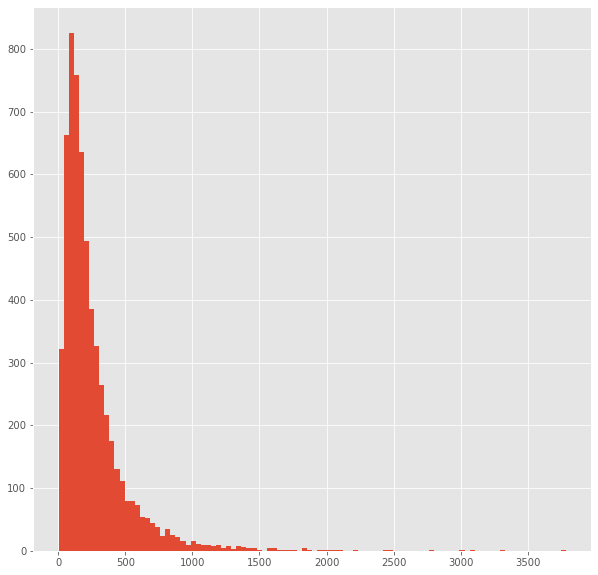

In [110]:
plt.figure(figsize=(10,10))
plt.hist(df_train_valid.duration,bins=100)
#plt.hist(df_train_valid.y,bins=100)
plt.show()

In [111]:
value_comparison = (df_train_valid.duration > 400)

In [112]:
value_comparison

0       False
1       False
2       False
3       False
4       False
        ...  
5995    False
5996    False
5997    False
5998    False
5999    False
Name: duration, Length: 6000, dtype: bool

In [113]:
df_train_valid.y[value_comparison].sum()

347

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 347.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

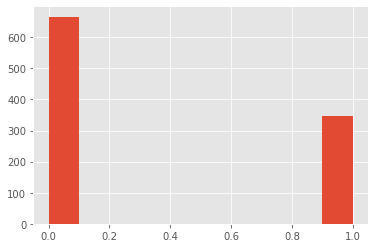

In [114]:
plt.hist(df_train_valid.y[value_comparison==True])

## Attribute Selection

In [115]:
# below, the label y can be included to generate the biased graph
genvars = df_train_valid[['age','job','marital','education','balance','housing','y']]
#genvars = df_train_valid[['age','job','marital','education','balance','housing','duration']]
genvars.describe()

,age,job,marital,education,balance,housing,y
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,1.908167,1.105833,0.828333,1.234333,2.416500,0.554667,0.113500
std,0.810870,0.458622,0.613672,0.744657,1.250582,0.497044,0.317229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000
75%,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,0.000000
max,4.000000,3.000000,2.000000,3.000000,4.000000,1.000000,1.000000


## Link-affinity matrices

To create the biased graph, add the link-affinity matrix of the label to the affinity matrix dictionary. Further, the label must be added to the matrix containing the attributes

In [116]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])


# duration
dur_alpha0 = 0.70
dur_alpha1 = 0.95
dur_beta1 = 0.25

aff_dur = np.array([[dur_alpha0,dur_beta1],
                  [dur_beta1,dur_alpha1]])

# outcome

y_alpha1 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha1,y_beta1],
                  [y_beta1,y_alpha1]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous,6:aff_y}

## MAG Model

In [117]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [118]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [119]:
A = A + A.T
np.sum(A) / 2

1840928.0

## Create and Plot the Graph

In [120]:
G = nx.from_numpy_matrix(A)

In [121]:
nx.is_connected(G)

True

In [122]:
# nx.draw(G,node_size=20)

In [123]:
features = pd.Series(df_train_valid.y)

In [124]:
df_train_valid.drop(columns=['y'],inplace=True)

In [125]:
not_invest = features.index[features == 0].tolist()
invest = features.index[features == 1].tolist()

In [126]:
pos = nx.spring_layout(G)

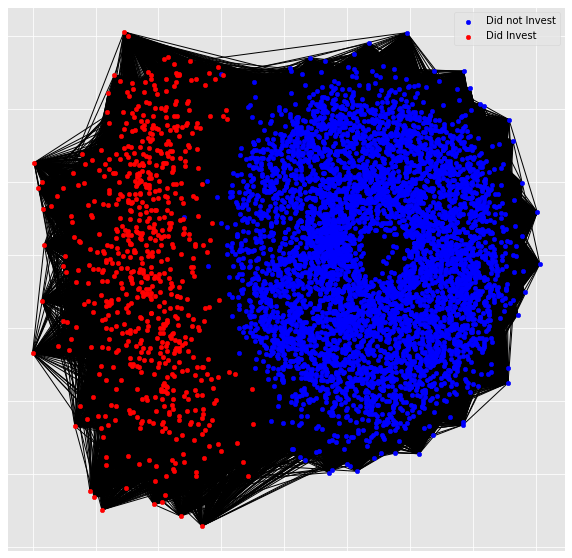

In [127]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=not_invest,node_size=20,node_color='b',label='Did not Invest')
nx.draw_networkx_nodes(G,pos,nodelist=invest,node_size=20,node_color='r',label='Did Invest')
nx.draw_networkx_edges(G,pos)

plt.legend()
plt.show()

## Prepare the Data for GNNs

In [128]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [129]:
df_train_valid

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2,1,1,1,0,1,1,0,0,280,6,1,0,2
1,3,1,0,1,0,3,1,0,1,331,2,1,0,2
2,2,1,1,1,0,3,1,0,1,158,1,1,0,2
3,2,1,2,2,0,4,1,1,1,106,1,1,0,2
4,1,1,1,1,0,2,1,0,1,228,2,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,3,1,1,1,0,2,0,0,1,13,8,0,3,2
5996,1,1,0,2,0,3,1,1,1,117,7,1,0,2
5997,2,3,0,1,0,0,1,0,1,372,1,1,0,2
5998,2,1,0,1,1,0,1,0,2,268,3,1,0,2


In [130]:
df_feature_train.reset_index(inplace=True,drop=True)
df_train_valid.age = df_feature_train.age
df_train_valid.balance = df_feature_train.balance
#df_train_valid.drop(columns = ['day','month'],inplace=True)
df_train_valid.duration = df_feature_train.duration


In [131]:
#df_train_valid.drop(columns = ['pdays'],inplace=True)
#df_train_valid.previous = df_feature_train.previous
df_train_valid.describe()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,41.054500,1.105833,0.828333,1.234333,0.018333,1307.726500,0.554667,0.166000,1.213833,256.750167,2.761000,0.947500,0.560667,1.752667
std,10.624359,0.458622,0.613672,0.744657,0.134165,2627.985913,0.497044,0.372112,0.556920,262.411309,3.027662,0.223052,1.715851,0.634739
min,19.000000,0.000000,0.000000,0.000000,0.000000,-2604.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,0.000000,1.000000,0.000000,74.000000,0.000000,0.000000,1.000000,102.000000,1.000000,1.000000,0.000000,2.000000
50%,39.000000,1.000000,1.000000,1.000000,0.000000,445.000000,1.000000,0.000000,1.000000,178.000000,2.000000,1.000000,0.000000,2.000000
75%,49.000000,1.000000,1.000000,2.000000,0.000000,1441.500000,1.000000,0.000000,2.000000,318.000000,3.000000,1.000000,0.000000,2.000000
max,95.000000,3.000000,2.000000,3.000000,1.000000,38279.000000,1.000000,1.000000,2.000000,3785.000000,41.000000,1.000000,25.000000,2.000000


In [132]:
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Prepare the dgl data and assign features and label

In [133]:
G_dgl = dgl.from_networkx(G)
feat = df_train_valid.copy(deep=True)
#feat = pd.get_dummies(feat)
scale = StandardScaler()
feat = pd.DataFrame(scale.fit_transform(feat))

G_dgl.ndata['feat'] =  torch.tensor(feat.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [134]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [135]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [136]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

## Define Dataloaders for minibatch training

In [137]:

batch_size = 50
#sampler = dgl.dataloading.MultiLayerNeighborSampler([4, 4, 4])
sampler = dgl.dataloading.MultiLayerNeighborSampler([5, 10])
#sampler = dgl.dataloading.MultiLayerNeighborSampler([None])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [138]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [139]:
print(len(train_nids))
print(len(valid_nids))
print(len(G.nodes()))

4829
1171
6000


## Define GraphSage Model

In [140]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

## Train GraphSage and get Results

In [141]:
model = SAGE(n_features, 124, n_labels, 2) #n_layers
opt = torch.optim.Adam(model.parameters())

In [ ]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)

Epoch: 0, Training Accuracy: 0.887, Training Loss: 0.330
Epoch: 0, Validation Accuracy: 0.885, Validation Loss: 0.303, Time: 2.5401
Epoch: 1, Training Accuracy: 0.892, Training Loss: 0.262
Epoch: 1, Validation Accuracy: 0.926, Validation Loss: 0.230, Time: 2.0724
Epoch: 2, Training Accuracy: 0.916, Training Loss: 0.213
Epoch: 2, Validation Accuracy: 0.933, Validation Loss: 0.189, Time: 2.0362
Epoch: 3, Training Accuracy: 0.923, Training Loss: 0.195
Epoch: 3, Validation Accuracy: 0.921, Validation Loss: 0.190, Time: 1.9299
Epoch: 4, Training Accuracy: 0.929, Training Loss: 0.182
Epoch: 4, Validation Accuracy: 0.934, Validation Loss: 0.168, Time: 1.8743
Epoch: 5, Training Accuracy: 0.929, Training Loss: 0.175
Epoch: 5, Validation Accuracy: 0.937, Validation Loss: 0.178, Time: 1.8223
Epoch: 6, Training Accuracy: 0.934, Training Loss: 0.175
Epoch: 6, Validation Accuracy: 0.939, Validation Loss: 0.151, Time: 1.7884
Epoch: 7, Training Accuracy: 0.934, Training Loss: 0.170
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 62, Validation Accuracy: 0.927, Validation Loss: 0.188, Time: 1.8808
Epoch: 63, Training Accuracy: 0.955, Training Loss: 0.121
Epoch: 63, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.8855
Epoch: 64, Training Accuracy: 0.953, Training Loss: 0.127
Epoch: 64, Validation Accuracy: 0.936, Validation Loss: 0.154, Time: 1.8767
Epoch: 65, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 65, Validation Accuracy: 0.953, Validation Loss: 0.132, Time: 1.8681
Epoch: 66, Training Accuracy: 0.953, Training Loss: 0.125
Epoch: 66, Validation Accuracy: 0.952, Validation Loss: 0.120, Time: 1.8610
Epoch: 67, Training Accuracy: 0.956, Training Loss: 0.121
Epoch: 67, Validation Accuracy: 0.947, Validation Loss: 0.131, Time: 1.8528
Epoch: 68, Training Accuracy: 0.959, Training Loss: 0.113
Epoch: 68, Validation Accuracy: 0.943, Validation Loss: 0.131, Time: 1.8446
Epoch: 69, Training Accuracy: 0.955, Training Loss: 0.118
Epoc

Epoch: 123, Training Accuracy: 0.963, Training Loss: 0.102
Epoch: 123, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.8076
Epoch: 124, Training Accuracy: 0.957, Training Loss: 0.110
Epoch: 124, Validation Accuracy: 0.966, Validation Loss: 0.103, Time: 1.8059
Epoch: 125, Training Accuracy: 0.957, Training Loss: 0.113
Epoch: 125, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.8022
Epoch: 126, Training Accuracy: 0.962, Training Loss: 0.104
Epoch: 126, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.7987
Epoch: 127, Training Accuracy: 0.960, Training Loss: 0.107
Epoch: 127, Validation Accuracy: 0.947, Validation Loss: 0.122, Time: 1.7951
Epoch: 128, Training Accuracy: 0.963, Training Loss: 0.099
Epoch: 128, Validation Accuracy: 0.956, Validation Loss: 0.121, Time: 1.7928
Epoch: 129, Training Accuracy: 0.959, Training Loss: 0.110
Epoch: 129, Validation Accuracy: 0.963, Validation Loss: 0.107, Time: 1.7892
Epoch: 130, Training Accuracy: 0.963, Training L

Epoch: 184, Training Accuracy: 0.964, Training Loss: 0.096
Epoch: 184, Validation Accuracy: 0.964, Validation Loss: 0.095, Time: 1.8373
Epoch: 185, Training Accuracy: 0.969, Training Loss: 0.087
Epoch: 185, Validation Accuracy: 0.956, Validation Loss: 0.108, Time: 1.8457
Epoch: 186, Training Accuracy: 0.962, Training Loss: 0.097
Epoch: 186, Validation Accuracy: 0.968, Validation Loss: 0.102, Time: 1.8452
Epoch: 187, Training Accuracy: 0.962, Training Loss: 0.094
Epoch: 187, Validation Accuracy: 0.965, Validation Loss: 0.092, Time: 1.8465
Epoch: 188, Training Accuracy: 0.969, Training Loss: 0.087
Epoch: 188, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.8452
Epoch: 189, Training Accuracy: 0.964, Training Loss: 0.093
Epoch: 189, Validation Accuracy: 0.962, Validation Loss: 0.090, Time: 1.8428
Epoch: 190, Training Accuracy: 0.965, Training Loss: 0.093
Epoch: 190, Validation Accuracy: 0.963, Validation Loss: 0.101, Time: 1.8401
Epoch: 191, Training Accuracy: 0.965, Training L

Epoch: 245, Training Accuracy: 0.972, Training Loss: 0.078
Epoch: 245, Validation Accuracy: 0.964, Validation Loss: 0.101, Time: 1.8281
Epoch: 246, Training Accuracy: 0.966, Training Loss: 0.087
Epoch: 246, Validation Accuracy: 0.960, Validation Loss: 0.107, Time: 1.8333
Epoch: 247, Training Accuracy: 0.967, Training Loss: 0.092
Epoch: 247, Validation Accuracy: 0.963, Validation Loss: 0.114, Time: 1.8318
Epoch: 248, Training Accuracy: 0.970, Training Loss: 0.081
Epoch: 248, Validation Accuracy: 0.965, Validation Loss: 0.114, Time: 1.8306
Epoch: 249, Training Accuracy: 0.973, Training Loss: 0.079
Epoch: 249, Validation Accuracy: 0.964, Validation Loss: 0.091, Time: 1.8292
Epoch: 250, Training Accuracy: 0.969, Training Loss: 0.087
Epoch: 250, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.8291
Epoch: 251, Training Accuracy: 0.966, Training Loss: 0.089
Epoch: 251, Validation Accuracy: 0.971, Validation Loss: 0.100, Time: 1.8284
Epoch: 252, Training Accuracy: 0.972, Training L

Epoch: 306, Training Accuracy: 0.972, Training Loss: 0.077
Epoch: 306, Validation Accuracy: 0.961, Validation Loss: 0.103, Time: 1.8540
Epoch: 307, Training Accuracy: 0.975, Training Loss: 0.068
Epoch: 307, Validation Accuracy: 0.962, Validation Loss: 0.100, Time: 1.8539
Epoch: 308, Training Accuracy: 0.973, Training Loss: 0.073
Epoch: 308, Validation Accuracy: 0.955, Validation Loss: 0.108, Time: 1.8537
Epoch: 309, Training Accuracy: 0.971, Training Loss: 0.074
Epoch: 309, Validation Accuracy: 0.972, Validation Loss: 0.090, Time: 1.8541
Epoch: 310, Training Accuracy: 0.973, Training Loss: 0.078
Epoch: 310, Validation Accuracy: 0.958, Validation Loss: 0.109, Time: 1.8544
Epoch: 311, Training Accuracy: 0.973, Training Loss: 0.076
Epoch: 311, Validation Accuracy: 0.962, Validation Loss: 0.101, Time: 1.8551
Epoch: 312, Training Accuracy: 0.969, Training Loss: 0.083
Epoch: 312, Validation Accuracy: 0.969, Validation Loss: 0.089, Time: 1.8565
Epoch: 313, Training Accuracy: 0.973, Training L

In [ ]:
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
len(predictions)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy validation set {}'.format(accuracy_score(valid_labels,predictions)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(valid_labels, predictions))

In [ ]:
best_accuracy

In [ ]:
model.parameters

In [ ]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

roc_auc_score(valid_labels,predictions)
#plot_roc_curve(logits, X_test, y_test) 

## Standard Machine Learning Results

### ANN

In [81]:
from sklearn.model_selection import train_test_split
f =  pd.get_dummies(features)
#x = df.drop(columns='y')
x_train, x_test, y_train, y_test = train_test_split(feat,f, test_size = 0.2, shuffle=True)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model_ann = Sequential()

model_ann.add(Dense(15, activation='relu'))
model_ann.add(Dense(8, activation='relu'))
model_ann.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_ann.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_ann.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=50, batch_size=1)

Epoch 1/50
4800/4800 [==============================] - 9s 2ms/step - loss: 0.3685 - accuracy: 0.8606 - val_loss: 0.2499 - val_accuracy: 0.8858
Epoch 2/50
4800/4800 [==============================] - 7s 2ms/step - loss: 0.2686 - accuracy: 0.8781 - val_loss: 0.2529 - val_accuracy: 0.8858
Epoch 3/50
4800/4800 [==============================] - 7s 1ms/step - loss: 0.2495 - accuracy: 0.8851 - val_loss: 0.2500 - val_accuracy: 0.8858
Epoch 4/50
4800/4800 [==============================] - 7s 2ms/step - loss: 0.2492 - accuracy: 0.8904 - val_loss: 0.2488 - val_accuracy: 0.8883
Epoch 5/50
4800/4800 [==============================] - 8s 2ms/step - loss: 0.2418 - accuracy: 0.8900 - val_loss: 0.2497 - val_accuracy: 0.8883
Epoch 6/50
4800/4800 [==============================] - 7s 2ms/step - loss: 0.2392 - accuracy: 0.8881 - val_loss: 0.2524 - val_accuracy: 0.8933
Epoch 7/50
4800/4800 [==============================] - 8s 2ms/step - loss: 0.2468 - accuracy: 0.8888 - val_loss: 0.2515 - val_accuracy:

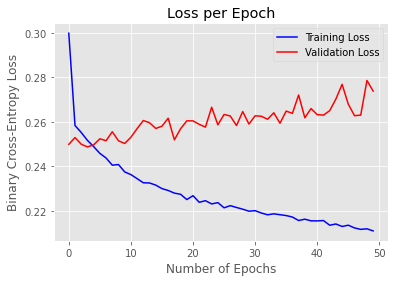

In [83]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

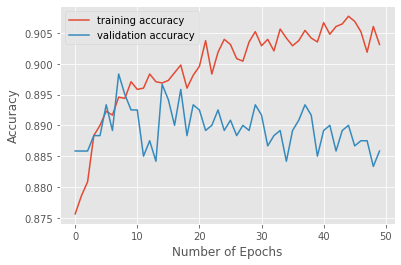

In [84]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Support Vector Machine

In [86]:
from sklearn import svm

svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(feat,svm_y, test_size = 0.6, shuffle=True)


clf = svm.SVC()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.90625
Validation Accuracy:  0.8830555555555556


## Random Forest Classifier

In [87]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-87-fdfda7052fc4>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.8875


##  Generate the Test Graph and prepare Test Dataset

In [88]:
df_test.age = df_test.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' else(1 if x == 'services' \
#                            else(2 if x == 'management' else(3 if x == 'blue-collar' \
#                                else(4 if x == 'self-employed' else(5 if x == 'technician' \
#                                    else(6 if x == 'entrepreneur' else(7 if x == 'admin.' \
#                        else(8 if x =='student' else(9 if x == 'housemaid' \
#                            else(10 if x == 'retired' else 11)))))))))))

#df.job = df.job.apply(lambda x: 0 if x == 'unemployed' or 'unknown' else(1 if x == 'services' \
#                        or x == 'management' or x == 'admin.' else(2 if x == 'blue-collar' or x == 'technician' \
#                                    or x == 'housemaid' else(3 if x == 'self-employed' or x == 'entrepreneur' \
#                                        else(4 if x == 'student' else 5)))))

df_test.job = df_test.job.apply(lambda x: 0 if x == 'student' else(2 if x == 'retired' else(3 if x == 'unemployed' or x == 'unknown' else 1)))


df_test.marital = df_test.marital.apply(lambda x: 0 if x == 'single' else(1 if x == 'married' else 2))

df_test.education = df_test.education.apply(lambda x: 0 if x == 'primary' else(1 if x == 'secondary' else(2 if x == 'tertiary' else 3)))

df_test.default = df_test.default.apply(lambda x: 0 if x == 'no' else 1)

df_test.balance = df_test.balance.apply(lambda x: 0 if x < 0 else(1 if x < 69. else(2 if x < 444. else(3 if x < 1480 else 4))))

df_test.housing = df_test.housing.apply(lambda x: 0 if x == 'no' else 1)

df_test.loan = df_test.loan.apply(lambda x: 0 if x == 'no' else 1)

df_test.contact = df_test.contact.apply(lambda x: 0 if x == 'telephone' else(1 if x == 'cellular' else 2))

df_test.duration = df_test.duration.apply(lambda x: 0 if x < 104. else(1 if x < 185 else(2 if x < 329 else 3)))

df_test.pdays = df_test.pdays.apply(lambda x: 1 if x > 150 or x == -1 else 0)

df_test.poutcome = df_test.poutcome.apply(lambda x: 0 if x == 'failure' else(1 if x == 'success' else 2))

df_test.y = df_test.y.apply(lambda x: 0 if x == 'no' else 1)

df_test.drop(columns = ['day','month'],inplace=True)


In [89]:
genvars = df_test.drop(columns=['previous','pdays','campaign','duration','contact','loan','default','poutcome','y'])
genvars

,age,job,marital,education,balance,housing
0,3,2,1,1,2,0
1,1,1,1,1,1,1
2,2,1,1,2,3,0
3,1,1,2,2,3,0
4,3,1,1,1,1,0
...,...,...,...,...,...,...
5995,1,1,0,1,0,1
5996,2,1,1,1,3,1
5997,3,1,0,2,4,0
5998,2,1,1,0,1,0


In [90]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])


# job

job_alpha0 = 0.90 # self
job_beta_wf = 0.60 # workforce
job_beta_nwf = 0.60 # not worforce

#aff_job = np.array([[job_alpha0, job_beta_wf , job_beta_wf , job_beta_wf , job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_alpha0, job_beta_wf, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_alpha0, job_beta_wf, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_alpha0, job_beta_nwf],
#                    [job_beta_nwf, job_beta_wf, job_beta_wf, job_beta_wf, job_beta_nwf, job_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_job = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])


# marital

mar_alpha0 = 0.85
mar_beta1 = 0.65

aff_mar = np.array([[mar_alpha0, mar_beta1, mar_beta1],
                    [mar_beta1, mar_alpha0, mar_beta1],
                    [mar_beta1, mar_beta1, mar_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])


# balance
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_bal = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0]])

# housing
hous_alpha0 = 0.60
hous_beta1 = 0.40

aff_hous = np.array([[hous_alpha0,hous_beta1],
                     [hous_beta1,hous_alpha0]])

# outcome

y_alpha0 = 0.95
y_beta1 = 0.25

aff_y = np.array([[y_alpha0,y_beta1],
                  [y_beta1,y_alpha0]])

aff = {}
aff = {0:aff_age, 1:aff_job ,2:aff_mar ,3:aff_edu ,4:aff_bal ,5:aff_hous}

In [91]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v) 

In [92]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [93]:
A = A + A.T
np.sum(A) / 2

2240786.0

In [94]:
G_test = nx.from_numpy_matrix(A)

In [95]:
test_features = pd.Series(df_test.y)

## Add Test Data to dgl Graph

In [96]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = df_test.drop(columns=['y'])
#feat_test = pd.get_dummies(feat_test)
scale = StandardScaler()
feat_test = pd.DataFrame(scale.fit_transform(feat_test))

embedding_test = torch.tensor(feat_test.values,dtype=torch.float)

G_dgl_test.ndata['feat'] =  embedding_test
#G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.2)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [97]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define Inference Function

In [98]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([None])  # one layer at a time, taking all neighbors
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            # Allocate a buffer of output representations for every node
            # Note that the buffer is on CPU memory.
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0].to(torch.device('cpu'))

                x = input_features[input_nodes]

                # the following code is identical to the loop body in model.forward()
                x = layer(bipartite, x)
                if l != model.n_layers - 1:
                    x = F.relu(x)
                    
                elif l == model.n_layers - 1:
                    x = F.log_softmax(x,dim=1)

                output_features[output_nodes] = x.cpu()
            input_features = output_features
    return output_features

## Load trained GraphSage model parameters and get Test results

In [99]:
model.load_state_dict(torch.load('model.pt'))
all_predictions = inference(model, G_dgl_test, node_features, 6000)

AttributeError: 'Sequential' object has no attribute 'load_state_dict'

In [ ]:
test_predictions = all_predictions[test_nids].argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))